In [18]:
import numpy as np
import os 
import keras.backend as K
from keras.models import save_model, load_model, Model
from keras.layers import Input, Dropout, BatchNormalization, add
from keras.layers import Conv2D, Conv2DTranspose
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
import scipy       #save image

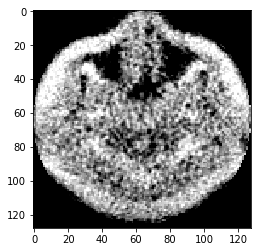

255.0

In [26]:
img1 = io.imread('train&test/train/low_count/'+'1_layer_6.8E6_2.png').astype("float")
plt.imshow(img1.T, plt.cm.gray)
plt.show()
img1.max()

In [19]:
train_num = 19   #训练图片数,前train num张
batch_size = 5
input_size_row = 128  #图像大小
input_size_col = 128


filename_X = os.listdir('train&test/train/train')  #training data
filename_Y = os.listdir('train&test/train/label') #label

In [9]:
def batch_train(train_num, input_size_row, input_size_col, filename_X, filename_Y, batch_size): #原来size 217*181
    rand_num = np.random.choice(train_num-1)
    img1 = io.imread('train&test/train/train/'+filename_X[rand_num]).astype("float")
    img2 = io.imread('train&test/train/label/'+filename_Y[rand_num]).astype("float")
    img1 = resize(img1, [input_size_row, input_size_col, 1], mode = 'constant')  #change size into 128*128
    img2 = resize(img2, [input_size_row, input_size_col, 1], mode = 'constant')

    img1 = np.reshape(img1,(1, input_size_row, input_size_col, 1))
    img2 = np.reshape(img2,(1, input_size_row, input_size_col, 1))

    img1 = img1/255
    img2 = img2/255

    batch_X = img1
    batch_Y = img2

    for i in range(1, batch_size):
        rand_num = np.random.choice(train_num-1)
        img1 = io.imread('train&test/train/train/'+filename_X[rand_num]).astype("float")
        img2 = io.imread('train&test/train/label/'+filename_Y[rand_num]).astype("float")
        img1 = resize(img1, [input_size_row, input_size_col, 1], mode = 'constant')
        img2 = resize(img2, [input_size_row, input_size_col, 1], mode = 'constant')
        #reshape
        img1 = np.reshape(img1,(1, input_size_row, input_size_col, 1))
        img2 = np.reshape(img2,(1, input_size_row, input_size_col, 1))
        #normalize
        img1 = img1/255
        img2 = img2/255

        batch_X = np.concatenate((batch_X, img1), axis = 0)
        batch_Y = np.concatenate((batch_Y, img2), axis = 0)
        
    return  batch_X, batch_Y, 

In [59]:
# NN model
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1,1), padding='same'):  #BN batchnormalization
    x = Conv2D(nb_filter, kernel_size, strides=strides, padding=padding, activation= 'relu')(x)
    x = BatchNormalization(axis=3)(x)
#     x = LeakyReLU(alpha=0.1)(x)
    return x

def Conv2D_BN_down(x, nb_filter, kernel_size, strides=(2,2), padding='same'):  #BN batchnormalization
    x = Conv2D(nb_filter, kernel_size, strides=strides, padding=padding, activation= 'relu')(x)
    x = BatchNormalization(axis=3)(x)
#     x = LeakyReLU(alpha=0.1)(x)
    return x

def Conv2dT_BN(x, filters, kernel_size, strides=(2,2), padding='same'):
    x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, activation = 'relu')(x)
    x = BatchNormalization(axis=3)(x)
#     x = LeakyReLU(alpha=0.1)(x)
    return x

#convolution(encoder)
inpt = Input(shape=(input_size_row, input_size_col, 1))

conv1 = Conv2d_BN(inpt, 32, (3, 3))
conv_down1 = Conv2D_BN_down(conv1, 32, (3,3))

conv2 = Conv2d_BN(conv_down1, 64, (3, 3))
conv_down2 = Conv2D_BN_down(conv2, 64, (3,3))

conv3 = Conv2d_BN(conv_down2, 128, (3, 3))
conv_down3 = Conv2D_BN_down(conv3, 128, (3,3))


conv4 = Conv2d_BN(conv_down3, 256, (3, 3))
conv_down4 = Conv2D_BN_down(conv4, 256, (3,3))

conv5 = Conv2d_BN(conv_down4, 512, (3, 3))
conv5 = Dropout(0.5)(conv5)
conv5 = Conv2d_BN(conv5, 512, (3, 3))
conv5 = Dropout(0.5)(conv5)


#transpose convolution(decoder)
convt1 = Conv2dT_BN(conv5, 256, (3, 3))
conadd1 = add([conv4, convt1]) #高度增加
conadd1 = Dropout(0.5)(conadd1)
conv6 = Conv2d_BN(conadd1, 256, (3, 3))  

convt2 = Conv2dT_BN(conv6, 128, (3, 3))
conadd2 = add([conv3, convt2])
conadd2 = Dropout(0.5)(conadd2)
conv7 = Conv2d_BN(conadd2, 128, (3, 3))


convt3 = Conv2dT_BN(conv7, 64, (3, 3))
conadd3 = add([conv2, convt3])
conadd3 = Dropout(0.5)(conadd3)
conv8 = Conv2d_BN(conadd3, 64, (3, 3))


convt4 = Conv2dT_BN(conv8, 32, (3, 3))
conadd4 = add([conv1, convt4])
conadd4 = Dropout(0.5)(conadd4)
conv9 = Conv2d_BN(conadd4, 32, (3, 3))

conv9 = Conv2d_BN(conv9, 1, (3, 3))
# conv9 = Dropout(0.5)(conv9)

outpt = add([conv9, inpt])

model = Model(inpt, outpt)
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['accuracy'])
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 128, 128, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 128, 128, 32) 128         conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 64, 64, 32)   9248        batch_normalization_40[0][0]     
__________________________________________________________________________________________________
batch_norm

In [14]:
#main
epochs =  20

for i in range(epochs):
#     print("iteration = ", i+1)
    train_X, train_Y = batch_train(train_num, input_size_row, input_size_col, filename_X, filename_Y, batch_size)
    model.fit(train_X, train_Y, epochs=1, verbose=2)
    if i % 5 == 0:
#         save_model(model, 'unet_relu.h5')
#         save_model(model, 'unet.h5')
          save_model(model, 'unet_denoise.h5')
    

Epoch 1/1
 - 4s - loss: 0.7811 - acc: 0.0000e+00
Epoch 1/1
 - 3s - loss: 0.7725 - acc: 0.0000e+00
Epoch 1/1
 - 3s - loss: 0.7702 - acc: 0.0000e+00
Epoch 1/1
 - 3s - loss: 0.7644 - acc: 8.5449e-05
Epoch 1/1
 - 3s - loss: 0.7625 - acc: 0.0000e+00
Epoch 1/1
 - 3s - loss: 0.7597 - acc: 4.8828e-05
Epoch 1/1
 - 3s - loss: 0.7599 - acc: 0.0000e+00
Epoch 1/1
 - 4s - loss: 0.7516 - acc: 1.2207e-04
Epoch 1/1
 - 4s - loss: 0.7527 - acc: 0.0000e+00
Epoch 1/1
 - 4s - loss: 0.7457 - acc: 7.3242e-05
Epoch 1/1
 - 3s - loss: 0.7425 - acc: 1.2207e-05
Epoch 1/1
 - 4s - loss: 0.7365 - acc: 3.6621e-05
Epoch 1/1
 - 3s - loss: 0.7337 - acc: 1.2207e-05
Epoch 1/1
 - 3s - loss: 0.7327 - acc: 0.0000e+00
Epoch 1/1
 - 3s - loss: 0.7291 - acc: 0.0000e+00
Epoch 1/1
 - 3s - loss: 0.7257 - acc: 0.0000e+00
Epoch 1/1
 - 3s - loss: 0.7240 - acc: 1.2207e-05
Epoch 1/1
 - 3s - loss: 0.7169 - acc: 7.3242e-05
Epoch 1/1
 - 3s - loss: 0.7180 - acc: 0.0000e+00
Epoch 1/1
 - 3s - loss: 0.7131 - acc: 1.2207e-05


In [10]:
#load model
# save_model(model, 'unet_denoise.h5')

model = load_model('unet_denoise.h5')

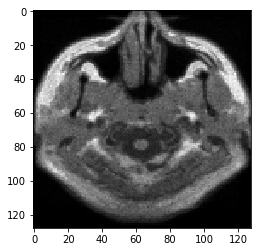

In [12]:
#test
test_filename_X = os.listdir('train&test/test/test_X/')
test_X = io.imread('train&test/test/test_X/'+test_filename_X[0]).astype("float")  #选第0张图片作测试
test_X = resize(test_X, [input_size_row, input_size_col, 1], mode = 'constant')
test_X = np.reshape(test_X,(1, input_size_row, input_size_col, 1))
plt.figure()  #输入
plt.imshow(test_X[0, :, :, 0], plt.cm.gray)
plt.show()
test_X = test_X/255

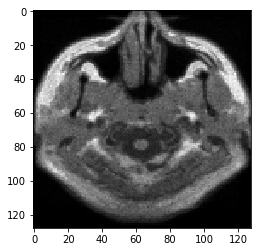

In [149]:
# 将模型作为一个层，输出第7层的输出
layer_model = Model(inputs=model.input, outputs=model.layers[0].output)
feature=layer_model.predict(test_X)
plt.figure()
plt.imshow(feature[0, :, :, 0],plt.cm.gray)    #输出
plt.show()

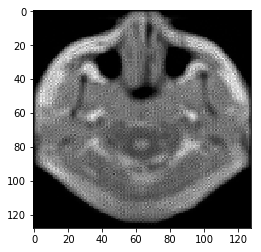

In [15]:
#unet的输出，有一个图像分割的作用
#pred—Y的值有些为负，可能要做变换01之间才能用EM
pred_Y = model.predict(test_X)
# pred_testY = pred_testY*255
plt.figure()
plt.imshow(pred_Y[0, :, :, 0],plt.cm.gray)    #输出
plt.show()

In [52]:
scipy.misc.imsave('a.png', pred_Y[0, :, :, 0])

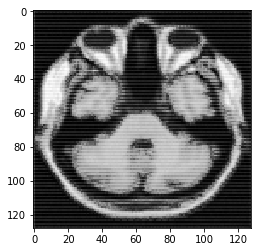

In [68]:
#NN 与conventional unet不一样，输出加上输入作为最终输出 compair
a = test_X + pred_Y
plt.figure()
plt.imshow(a[0, :, :, 0],plt.cm.gray)    #输出
plt.show()

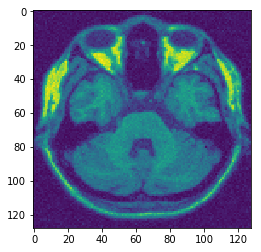

In [16]:
train_X = io.imread('train&test/train/train/'+filename_X[7]).astype("float")
train_X = resize(train_X, [input_size_row, input_size_col, 1], mode = 'constant')
train_X = np.reshape(train_X,(1, input_size_row, input_size_col, 1))

plt.figure()                 #测试集的输入
plt.imshow(train_X[0, :, :, 0])
plt.show()

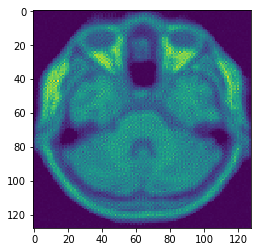

In [17]:
# train_X = np.reshape(train_X[3, :, :, 0],(1,128,128,1))
train_X /= 255
pred_Y = model.predict(train_X)   #测试集里的某一张的输出

plt.figure()
plt.imshow(pred_Y[0,:,:,0])
plt.show()


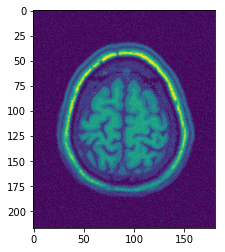

44

In [310]:
rand_num = np.random.choice(train_num-1)
img1 = io.imread('noise_5/'+filename_X[rand_num]).astype("float")
plt.figure()
plt.imshow(img1)
plt.show()
rand_num